## Import

In [1]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from tqdm.auto import tqdm
import cv2

from tensorflow.keras.applications import VGG19

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D, Input
import tensorflow.keras as keras
from tensorflow.data import Dataset


from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

2022-05-12 16:13:55.871585: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


## Data Pre-processing

In [2]:
def get_train_data(data_dir):
    img_path_list = []
    label_list = []
    for case_name in os.listdir(data_dir):
        current_path = os.path.join(data_dir, case_name)
        if os.path.isdir(current_path):
            # get image path
            img_path_list.extend(glob(os.path.join(current_path, 'image', '*.jpg')))
            img_path_list.extend(glob(os.path.join(current_path, 'image', '*.png')))
            
            # get label
            label_df = pd.read_csv(current_path+'/label-{}.csv'.format(str(int(case_name[-2:]))))
            label_list.extend(label_df['leaf_weight'])
                
    return img_path_list, label_list

def get_test_data(data_dir):
    # get image path
    img_path_list = glob(os.path.join(data_dir, 'image', '*.jpg'))
    img_path_list.extend(glob(os.path.join(data_dir, 'image', '*.png')))
    img_path_list.sort(key=lambda x:int(x.split('/')[-1].split('.')[0]))
    return img_path_list

In [3]:
def load_img_numpy(img_dir, target_size) :
    img = cv2.imread(img_dir)
    img = cv2.resize(img, dsize=target_size)
    img = img.astype(np.float32) / 255.0 # normalize 
    return img

In [4]:
def create_dataset(img_dir, label, target_size, batch_size=None) :    
    img = [] # 원본이미지
    
    ## 최적화가 필요한 부분
    for i in img_dir:
        image = load_img_numpy(i, target_size)
        img.append(image)
        
    x = Dataset.from_tensor_slices(img)
    y = Dataset.from_tensor_slices(label)
    dataset = Dataset.zip((x, y))
    
    if batch_size is not None:
        dataset = dataset.batch(batch_size, drop_remainder=True).repeat()
   
    return dataset

In [5]:
def load_test_img_numpy(img_dir, target_size) :
    img = cv2.imread(img_dir)
    img = cv2.resize(img, dsize=target_size)
    img = img.astype(np.float32) / 255.0
    return img

def create_test_dataset(img_dir, target_size, batch_size=None) :
    file_name = [x.split('/')[-1][:-4] for x in img_dir]
    x_img = []

    for i in tqdm(img_dir,
                total=len(img_dir),
                position=0,
                leave=True):
        img = load_test_img_numpy(i, target_size)
        x_img.append(img)

    dataset = Dataset.from_tensor_slices(x_img)
    
    if batch_size is not None :
        dataset = dataset.batch(batch_size, drop_remainder=True).repeat()
       
    return dataset, file_name

## Load Data Set

In [6]:
IMAGE_SIZE = 224
BATCH_SIZE = 8
LEARNING_RATE = 2e-4

all_img_path, all_label = get_train_data('/home/lab05/AI_proj_Team2/AI_proj_Team2/data/train/')
test_img_path = get_test_data('/home/lab05/AI_proj_Team2/AI_proj_Team2/data/test')

## Train / Validation Split

In [7]:
# Train : Validation = 0.8 : 0.2 Split
train_len = int(len(all_img_path)*0.8)

train_img_path = all_img_path[:train_len]
train_label = all_label[:train_len]

vali_img_path = all_img_path[train_len:]
vali_label = all_label[train_len:]

In [11]:
train_dataset = create_dataset(train_img_path, train_label, (IMAGE_SIZE, IMAGE_SIZE), BATCH_SIZE)
valid_dataset = create_dataset(vali_img_path, vali_label, (IMAGE_SIZE, IMAGE_SIZE), BATCH_SIZE )

2022-05-12 16:18:29.596014: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 766488576 exceeds 10% of free system memory.


In [12]:
train_dataset

<RepeatDataset shapes: ((8, 224, 224, 3), (8,)), types: (tf.float32, tf.float32)>

In [13]:
valid_dataset

<RepeatDataset shapes: ((8, 224, 224, 3), (8,)), types: (tf.float32, tf.float32)>

## VGG16 Model

In [14]:
base_model = VGG19(
    weights='imagenet',
    include_top = False,
    input_shape = (IMAGE_SIZE,IMAGE_SIZE) + (3,)
)
base_model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [15]:
from tensorflow.keras.regularizers import *

LAMBDA_VAL = 0.001

# base_model.trainable = False
# model = Sequential()
# model.add(base_model)
# model.add(GlobalAveragePooling2D()) # Flatten??
# model.add(Dropout(0.3))
# model.add(Dense(64, activation='relu'))
# model.add(Dense(1, activation='linear', kernel_regularizer=L2(l2=LAMBDA_VAL)))

base_model.trainable = False
model = Sequential()

model.add(base_model)

model.add(Flatten())

model.add(Dense(units=256,
                activation='relu'))

model.add(Dropout(rate=0.5))
model.add(Dense(units=128,
                activation='relu'))

model.add(Dense(units=64,
                activation='relu'))

model.add(Dropout(rate=0.5))

model.add(Dense(units=1,
                activation='linear',  kernel_regularizer=L2(l2=LAMBDA_VAL)))


# Early Stopping
es = EarlyStopping(monitor='val_loss',
                   mode='auto',
                   patience=5,
                   verbose=1)

# Checkpoint
# model_checkpoint = './{epoch:06d}-{val_acc:0.6f}-{acc:0.6f}.ckpt'

# checkpointer = ModelCheckpoint(
#     filepath=model_checkpoint,
#     verbose=1,
#     period=2,
#     save_best_weights=True,
#     mode='auto',
#     monitor='val_acc'
# )



In [16]:
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss='mse',
              metrics=['mae'])


EPOCHS = 30
STEPS_PER_EPOCH = len(train_img_path) // BATCH_SIZE
VAL_STEPS = len(vali_img_path) // BATCH_SIZE

history = model.fit(train_dataset, epochs=EPOCHS,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=valid_dataset,
                    validation_steps = VAL_STEPS,
                    # callbacks=[es, checkpointer],
                    verbose=1)

model.save('./pretrained_model_efficentnetb7.h5')

2022-05-12 16:21:21.216962: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 766488576 exceeds 10% of free system memory.


Epoch 1/30


2022-05-12 16:21:22.376047: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-05-12 16:21:22.397950: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2499995000 Hz
2022-05-12 16:21:22.493480: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-05-12 16:21:22.718181: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


159/159 [==============================] - 14s 71ms/step - loss: 15402.0079 - mae: 78.0685 - val_loss: 10195.2920 - val_mae: 74.1492
Epoch 2/30
159/159 [==============================] - 11s 69ms/step - loss: 10369.7982 - mae: 72.9319 - val_loss: 10173.6641 - val_mae: 72.1017
Epoch 3/30
159/159 [==============================] - 11s 69ms/step - loss: 9326.7200 - mae: 69.3372 - val_loss: 10161.9482 - val_mae: 71.6011
Epoch 4/30
159/159 [==============================] - 11s 69ms/step - loss: 8653.1208 - mae: 65.9489 - val_loss: 10146.9580 - val_mae: 70.8243
Epoch 5/30
159/159 [==============================] - 11s 69ms/step - loss: 8800.7460 - mae: 66.4469 - val_loss: 10132.7119 - val_mae: 71.4767
Epoch 6/30
159/159 [==============================] - 11s 69ms/step - loss: 8539.6886 - mae: 65.5547 - val_loss: 10049.8633 - val_mae: 71.9018
Epoch 7/30
159/159 [==============================] - 11s 68ms/step - loss: 8241.5557 - mae: 64.5412 - val_loss: 10191.3369 - val_mae: 69.3855
Epoch 8/

Text(0.5, 1.0, 'Training and Validation MAE')

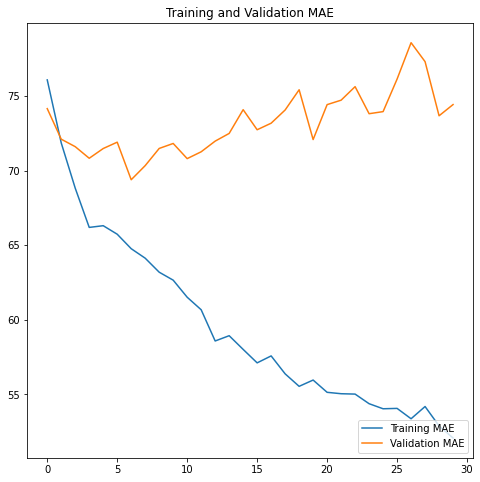

In [17]:
plt.figure(figsize=(8, 8))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.legend(loc='lower right')
plt.title('Training and Validation MAE')

## Fine-tuning


In [18]:
base_model.trainable=True
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  22


In [19]:
fine_tune_at= int(len(base_model.layers)*0.9)

for i, layer in enumerate(base_model.layers[:fine_tune_at]):
    if 'bn' not in layer.name :
        layer.trainable = True

In [20]:
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE/10),
              loss='mse',
              metrics=['mae'])

In [21]:
FINE_TUNE_EPOCHS = 30 
history = model.fit(train_dataset, epochs=FINE_TUNE_EPOCHS,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=valid_dataset,
                    validation_steps = VAL_STEPS,
                    # callbacks=[es, checkpointer],
                    verbose=1)

model.save('./fine_tuned_model.h5')

2022-05-12 16:27:11.812368: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 766488576 exceeds 10% of free system memory.


Epoch 1/30
159/159 [==============================] - 31s 183ms/step - loss: 9060.3352 - mae: 64.2138 - val_loss: 11579.2637 - val_mae: 71.5470
Epoch 2/30
159/159 [==============================] - 29s 184ms/step - loss: 8556.9802 - mae: 63.8506 - val_loss: 10451.7285 - val_mae: 72.7835
Epoch 3/30
159/159 [==============================] - 29s 185ms/step - loss: 7378.4606 - mae: 61.0359 - val_loss: 9879.1201 - val_mae: 74.9753
Epoch 4/30
159/159 [==============================] - 29s 184ms/step - loss: 6121.6101 - mae: 55.3408 - val_loss: 10429.1875 - val_mae: 73.6690
Epoch 5/30
159/159 [==============================] - 29s 184ms/step - loss: 7078.5073 - mae: 60.4650 - val_loss: 10278.4795 - val_mae: 72.9374
Epoch 6/30
159/159 [==============================] - 29s 186ms/step - loss: 5391.0802 - mae: 52.5889 - val_loss: 9708.0537 - val_mae: 72.5191
Epoch 7/30
159/159 [==============================] - 30s 186ms/step - loss: 5525.1322 - mae: 52.3110 - val_loss: 10171.4277 - val_mae: 73

Text(0.5, 1.0, 'Training and Validation fine-tuning MAE')

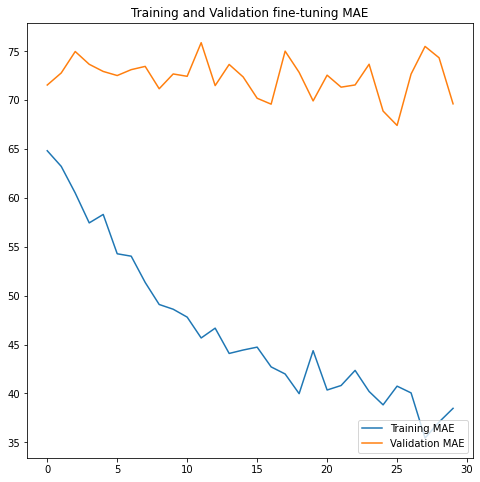

In [22]:
plt.figure(figsize=(8, 8))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.legend(loc='lower right')
plt.title('Training and Validation fine-tuning MAE')

## CustomDataset

---


## 규제 없는 모델
&loss = mae

In [23]:

base_model.trainable = False
model2 = Sequential()

model2.add(base_model)

model2.add(Flatten())

model2.add(Dense(units=256,
                activation='relu'))

model2.add(Dropout(rate=0.5))
model2.add(Dense(units=128,
                activation='relu'))

model2.add(Dense(units=64,
                activation='relu'))

model2.add(Dropout(rate=0.5))

model2.add(Dense(units=1,
                activation='linear'))


checkpoint_filepath = './no_regul_pretrain_best_model.h5'
checkpointer = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_mae',
    save_best_only=True,
    verbose=1
)

model2.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss='mae',
              metrics=['mae'])

In [24]:
history2 = model2.fit(train_dataset, epochs=EPOCHS,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=valid_dataset,
                    validation_steps = VAL_STEPS,
                    callbacks=[checkpointer],
                    verbose=1)

2022-05-12 16:43:30.034771: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 766488576 exceeds 10% of free system memory.


Epoch 1/30
159/159 [==============================] - 12s 71ms/step - loss: 77.2141 - mae: 77.2141 - val_loss: 69.4449 - val_mae: 69.4449

Epoch 00001: val_mae improved from inf to 69.44485, saving model to ./no_regul_pretrain_best_model.h5
Epoch 2/30
159/159 [==============================] - 11s 70ms/step - loss: 70.0335 - mae: 70.0335 - val_loss: 67.5610 - val_mae: 67.5610

Epoch 00002: val_mae improved from 69.44485 to 67.56102, saving model to ./no_regul_pretrain_best_model.h5
Epoch 3/30
159/159 [==============================] - 11s 70ms/step - loss: 65.2288 - mae: 65.2288 - val_loss: 66.6582 - val_mae: 66.6582

Epoch 00003: val_mae improved from 67.56102 to 66.65819, saving model to ./no_regul_pretrain_best_model.h5
Epoch 4/30
159/159 [==============================] - 11s 70ms/step - loss: 58.7927 - mae: 58.7927 - val_loss: 66.2924 - val_mae: 66.2924

Epoch 00004: val_mae improved from 66.65819 to 66.29240, saving model to ./no_regul_pretrain_best_model.h5
Epoch 5/30
159/159 [=

Text(0.5, 1.0, 'Training and Validation MAE')

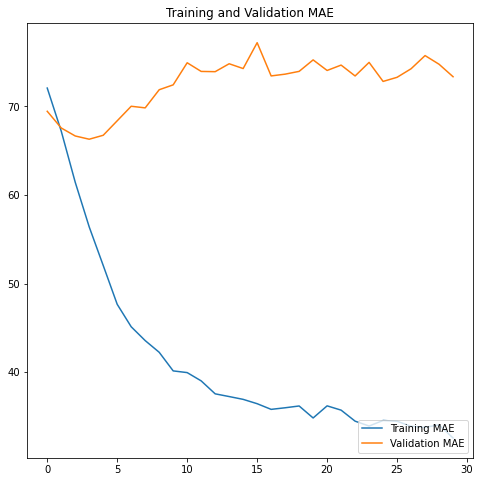

In [25]:
plt.figure(figsize=(8, 8))
plt.plot(history2.history['mae'], label='Training MAE')
plt.plot(history2.history['val_mae'], label='Validation MAE')
plt.legend(loc='lower right')
plt.title('Training and Validation MAE')

## fine tune

In [26]:
base_model.trainable=True

fine_tune_at = int(len(base_model.layers) * 0.9)
for layer in base_model.layers[:fine_tune_at] :
    layer.trainable = True

In [27]:
model2.compile(optimizer=Adam(learning_rate=LEARNING_RATE/10),
              loss='mae',
              metrics=['mae'])

checkpoint_filepath = './no_regul_finetune_best_model.h5'
checkpointer = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_mae',
    save_best_only=True,
    verbose=1
)

history2 = model2.fit(train_dataset, epochs=EPOCHS,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=valid_dataset,
                    validation_steps = VAL_STEPS,
                    callbacks=[checkpointer],
                    verbose=1)

model2.save('./by_chance_noregul_finetunemoedl.h5')

2022-05-12 16:49:21.939568: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 766488576 exceeds 10% of free system memory.


Epoch 1/30
159/159 [==============================] - 28s 174ms/step - loss: 39.6794 - mae: 39.6794 - val_loss: 79.5630 - val_mae: 79.5630

Epoch 00001: val_mae improved from inf to 79.56303, saving model to ./no_regul_finetune_best_model.h5
Epoch 2/30
159/159 [==============================] - 27s 173ms/step - loss: 44.5723 - mae: 44.5723 - val_loss: 72.8138 - val_mae: 72.8138

Epoch 00002: val_mae improved from 79.56303 to 72.81383, saving model to ./no_regul_finetune_best_model.h5
Epoch 3/30
159/159 [==============================] - 27s 173ms/step - loss: 47.0900 - mae: 47.0900 - val_loss: 76.5105 - val_mae: 76.5105

Epoch 00003: val_mae did not improve from 72.81383
Epoch 4/30
159/159 [==============================] - 28s 173ms/step - loss: 42.1234 - mae: 42.1234 - val_loss: 79.2941 - val_mae: 79.2941

Epoch 00004: val_mae did not improve from 72.81383
Epoch 5/30
159/159 [==============================] - 28s 174ms/step - loss: 39.9008 - mae: 39.9008 - val_loss: 77.2580 - val_mae

Text(0.5, 1.0, 'Training and Validation MAE')

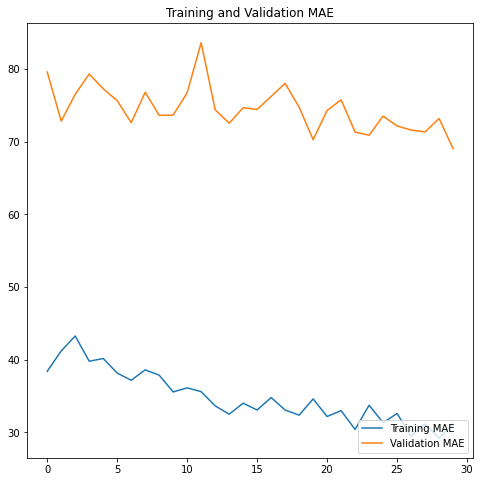

In [28]:
plt.figure(figsize=(8, 8))
plt.plot(history2.history['mae'], label='Training MAE')
plt.plot(history2.history['val_mae'], label='Validation MAE')
plt.legend(loc='lower right')
plt.title('Training and Validation MAE')

## learning rate 변경

In [29]:
 base_model = VGG19(
    weights='imagenet',
    include_top = False,
    input_shape = (IMAGE_SIZE,IMAGE_SIZE) + (3,)
)

In [30]:

LEARNING_RATE = 1e-4

base_model.trainable = False
model3 = Sequential()

model3.add(base_model)

model3.add(Flatten())

model3.add(Dense(units=256,
                activation='relu'))

model3.add(Dropout(rate=0.5))
model3.add(Dense(units=128,
                activation='relu'))

model3.add(Dense(units=64,
                activation='relu'))

model3.add(Dropout(rate=0.5))

model3.add(Dense(units=1,
                activation='linear'))

checkpoint_filepath = './no_regul_pretrain_best_model_lr.h5'

checkpointer = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_mae',
    save_best_only=True,
    verbose=1
)

model3.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss='mae',
              metrics=['mae'])

In [31]:
history3 = model3.fit(train_dataset, epochs=EPOCHS,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=valid_dataset,
                    validation_steps = VAL_STEPS,
                    callbacks=[checkpointer],
                    verbose=1)


Epoch 1/30
159/159 [==============================] - 12s 73ms/step - loss: 77.9060 - mae: 77.9060 - val_loss: 69.6926 - val_mae: 69.6926

Epoch 00001: val_mae improved from inf to 69.69263, saving model to ./no_regul_pretrain_best_model_lr.h5
Epoch 2/30
159/159 [==============================] - 11s 71ms/step - loss: 71.6517 - mae: 71.6517 - val_loss: 68.6489 - val_mae: 68.6489

Epoch 00002: val_mae improved from 69.69263 to 68.64894, saving model to ./no_regul_pretrain_best_model_lr.h5
Epoch 3/30
159/159 [==============================] - 11s 70ms/step - loss: 69.8354 - mae: 69.8354 - val_loss: 67.6897 - val_mae: 67.6897

Epoch 00003: val_mae improved from 68.64894 to 67.68970, saving model to ./no_regul_pretrain_best_model_lr.h5
Epoch 4/30
159/159 [==============================] - 11s 69ms/step - loss: 67.2082 - mae: 67.2082 - val_loss: 67.4329 - val_mae: 67.4329

Epoch 00004: val_mae improved from 67.68970 to 67.43293, saving model to ./no_regul_pretrain_best_model_lr.h5
Epoch 5/3

Text(0.5, 1.0, 'Training and Validation MAE')

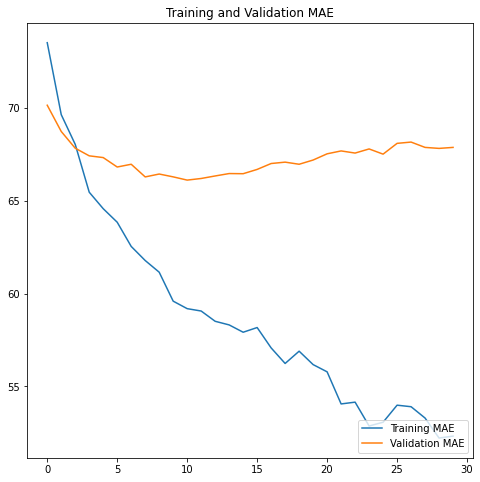

In [55]:
plt.figure(figsize=(8, 8))
plt.plot(history3.history['mae'], label='Training MAE')
plt.plot(history3.history['val_mae'], label='Validation MAE')
plt.legend(loc='lower right')
plt.title('Training and Validation MAE')

## finetune

In [56]:
base_model.trainable=True

fine_tune_at = int(len(base_model.layers) * 0.9)
for layer in base_model.layers[:fine_tune_at] :
    layer.trainable = True

In [57]:
checkpoint_filepath = './no_regul_pretrain_best_model_lr.h5'
checkpointer = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_mae',
    save_best_only=True,
    verbose=1
)

model3.compile(optimizer=Adam(learning_rate=LEARNING_RATE/10),
              loss='mae',
              metrics=['mae'])

history3 = model3.fit(train_dataset, epochs=EPOCHS,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=valid_dataset,
                    validation_steps = VAL_STEPS,
                    callbacks=[checkpointer],
                    verbose=1)

Epoch 1/30
159/159 [==============================] - 10s 59ms/step - loss: 50.4791 - mae: 50.4791 - val_loss: 67.9750 - val_mae: 67.9750

Epoch 00001: val_mae improved from inf to 67.97500, saving model to ./no_regul_pretrain_best_model_lr.h5
Epoch 2/30
159/159 [==============================] - 9s 58ms/step - loss: 49.8406 - mae: 49.8406 - val_loss: 67.8893 - val_mae: 67.8893

Epoch 00002: val_mae improved from 67.97500 to 67.88928, saving model to ./no_regul_pretrain_best_model_lr.h5
Epoch 3/30
159/159 [==============================] - 9s 58ms/step - loss: 51.5339 - mae: 51.5339 - val_loss: 67.9384 - val_mae: 67.9384

Epoch 00003: val_mae did not improve from 67.88928
Epoch 4/30
159/159 [==============================] - 9s 58ms/step - loss: 52.5414 - mae: 52.5414 - val_loss: 68.0061 - val_mae: 68.0061

Epoch 00004: val_mae did not improve from 67.88928
Epoch 5/30
159/159 [==============================] - 9s 58ms/step - loss: 51.6303 - mae: 51.6303 - val_loss: 68.0880 - val_mae: 6

Text(0.5, 1.0, 'Training and Validation MAE')

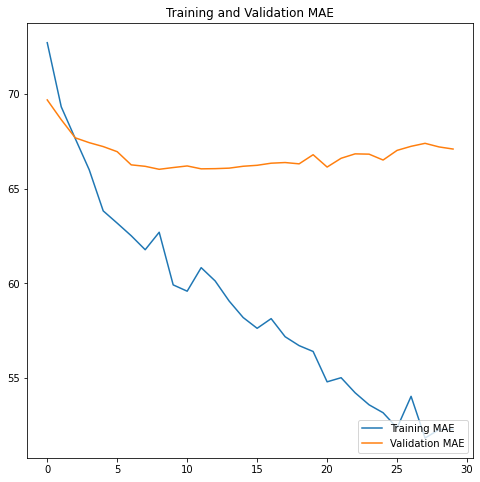

In [32]:
plt.figure(figsize=(8, 8))
plt.plot(history3.history['mae'], label='Training MAE')
plt.plot(history3.history['val_mae'], label='Validation MAE')
plt.legend(loc='lower right')
plt.title('Training and Validation MAE')

## Prediction

In [61]:
len(test_img_path)

460

In [62]:
PRED_BATCH_SIZE = 10

In [64]:
test_dataset, file_names = create_test_dataset(test_img_path, (IMAGE_SIZE, IMAGE_SIZE), PRED_BATCH_SIZE )

  0%|          | 0/460 [00:00<?, ?it/s]

In [65]:
eff_model = tf.keras.models.load_model('./no_regul_pretrain_best_model_lr.h5')

STEPS = len(test_img_path) / PRED_BATCH_SIZE
prediction = eff_model.predict(test_dataset,
                            batch_size = PRED_BATCH_SIZE,
                            steps=STEPS)


## Submission

In [67]:
submission = pd.read_csv('/home/lab05/AI_proj_Team2/AI_proj_Team2/data/sample_submission.csv')
submission['leaf_weight'] = prediction.squeeze()
submission.to_csv('./submit_VGG16_CNN.csv', index=False)


